# Reinforcement Learning

In the code below we use DDPG to find a policy that can generate optimal trading trajectories that minimize implementation shortfall, and can be benchmarked against the Almgren and Chriss model. We will implement a typical reinforcement learning workflow to train the actor and critic using the simulation environment. We feed the states observed from our simulator to an agent. The Agent first predicts an action using the actor model and performs the action in the environment. Then, environment returns the reward and new state. This process continues for the given number of episodes. To get accurate results, you should run the code at least 10,000 episodes.

In [1]:
import numpy as np

import syntheticChrissAlmgren2 as sca
from ddpg_agent import Agent
from noise import OUNoise

from collections import deque

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def train_agent(env, agent, lqt, n_trades, tr, episodes):
    shortfall_hist = np.array([])
    shortfall_deque = deque(maxlen=100)
    total_rewards = np.array([])
    total_rewards_deque = deque(maxlen=100)

    for episode in range(episodes): 
        total_reward = 0
        # Reset the environment
        cur_state = env.reset(seed=episode, liquid_time=lqt, num_trades=n_trades, lamb=tr)

        # Set the environment to make transactions
        env.start_transactions()

        for i in range(n_trades + 1):
            # Predict the best action for the current state  return [0,1]
            action = agent.act(cur_state, add_noise=True)
            
            # Action is performed and new state, reward, info are received
            new_state, reward, done, info = env.step(action)

            total_reward += reward
            
            # Current state, action, reward, new state are stored in the experience replay
            # Important fix, set action from [0,1] back to [-1,1], otherwise change agent actor to use sigmoid [0,1]
            action = 2.0 * action - 1.0
            agent.step(cur_state, action, reward, new_state, done)
            
            # Roll over new state
            cur_state = new_state

            if info.done:
                agent.reset()
                total_rewards = np.append(total_rewards, total_reward)
                total_rewards_deque.append(total_reward)
                shortfall_hist = np.append(shortfall_hist, info.implementation_shortfall)
                shortfall_deque.append(info.implementation_shortfall)
                break
        
        if (episode + 1) % 100 == 0:  # Print average shortfall over last 100 episodes
            print('\rEpisode [{}/{}]\tAverage Shortfall: ${:,.2f}\tAverage Reward: {:,.2f}'.format(episode + 1, 
                                                                                                   episodes, 
                                                                                                   np.mean(shortfall_deque),
                                                                                                   np.mean(total_rewards_deque)))


    print('\nAverage Implementation Shortfall: ${:,.2f} \n'.format(np.mean(shortfall_hist)))
    return shortfall_hist, total_rewards

def plot_shortfall_hist(shortfall_hist):

    print('Average Implementation Shortfall: ${:,.2f}'.format(shortfall_hist.mean()))
    print('Standard Deviation of the Implementation Shortfall: ${:,.2f}'.format(shortfall_hist.std()))

    plt.plot(shortfall_hist, 'cyan', label='')
    plt.xlim(0, len(shortfall_hist))
    ax = plt.gca()
    ax.set_facecolor('k')
    ax.set_xlabel('Episode', fontsize=15)
    ax.set_ylabel('Implementation Shortfall (US $)', fontsize=15)
    ax.axhline(np.mean(shortfall_hist), 0, 1, color='m', label='Average')
    yNumFmt = mticker.StrMethodFormatter('${x:,.0f}')
    ax.yaxis.set_major_formatter(yNumFmt)
    plt.legend()
    plt.show()

def eval_agent(lq_time = 60, nm_trades = 60, tr_risk = 1e-6, trs = 100, agent=None):
    # Create simulation environment
    env = sca.MarketEnvironment()

    # Reset the enviroment
    env.reset(liquid_time = lq_time, num_trades = nm_trades, lamb = tr_risk)

    # Set the initial shortfall to zero
    shortfall_hist = np.array([])

    for episode in range(trs):
         # Reset the enviroment
        cur_state = env.reset(seed = episode, liquid_time = lq_time, num_trades = nm_trades, lamb = tr_risk)

        # set the environment to make transactions
        env.start_transactions()

        for i in range(nm_trades + 1):
            # Predict the best action without noise
            action = agent.act(cur_state, add_noise=False)
            new_state, _, _, info = env.step(action)
            # print(reward)

            # Roll over new state
            cur_state = new_state

            if info.done:
                shortfall_hist = np.append(shortfall_hist, info.implementation_shortfall)
                break
    
    plot_shortfall_hist(shortfall_hist)


In [2]:
# Create simulation environment
env = sca.MarketEnvironment()

action_size = env.action_space_dimension()
state_size = env.observation_space_dimension()

noise = OUNoise(action_size, seed=0)

# Initialize Feed-forward DNNs for Actor and Critic models. 
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0, noise=noise)
# Set the liquidation time
lqt = 60
# Set the number of trades
n_trades = 60
# Set trader's risk aversion
tr = 1e-6
# Set the number of episodes to run the simulation
episodes = 1000

# Train the agent and get the shortfall history
shortfall_hist, total_rewards = train_agent(env, agent, lqt, n_trades, tr, episodes)

Episode [100/1000]	Average Shortfall: $111,498.55	Average Reward: 15.59
Episode [200/1000]	Average Shortfall: $352,235.75	Average Reward: 15.57
Episode [300/1000]	Average Shortfall: $44,815.03	Average Reward: 15.75
Episode [400/1000]	Average Shortfall: $484,800.31	Average Reward: 15.53
Episode [500/1000]	Average Shortfall: $204,635.65	Average Reward: 15.65
Episode [600/1000]	Average Shortfall: $189,102.66	Average Reward: 15.73
Episode [700/1000]	Average Shortfall: $185,196.64	Average Reward: 15.74
Episode [800/1000]	Average Shortfall: $459,041.33	Average Reward: 15.57
Episode [900/1000]	Average Shortfall: $386,016.56	Average Reward: 15.57
Episode [1000/1000]	Average Shortfall: $-47,703.32	Average Reward: 15.78

Average Implementation Shortfall: $236,963.91 



Average Implementation Shortfall: $236,963.91
Standard Deviation of the Implementation Shortfall: $1,533,272.10


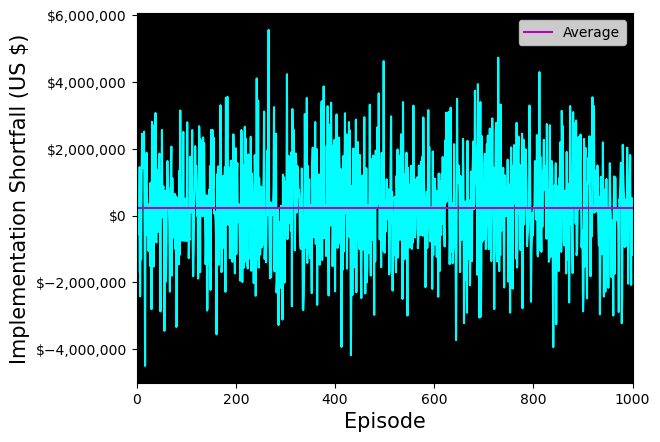

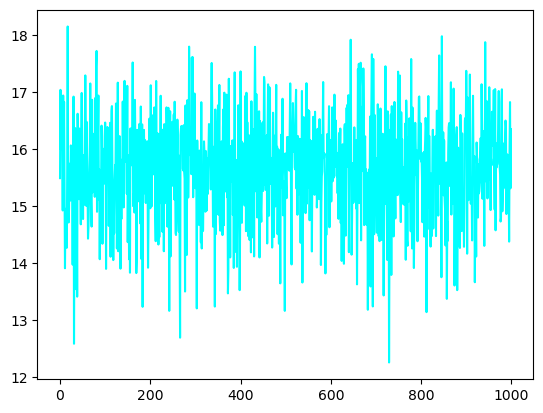

In [3]:
plot_shortfall_hist(shortfall_hist)
plt.plot(total_rewards, 'cyan', label='Total Rewards')
# eval_agent(trs=1000, agent=agent)

In [4]:
from td3_agent import TD3Agent

# Create simulation environment
env = sca.MarketEnvironment()

action_size = env.action_space_dimension()
state_size = env.observation_space_dimension()

# Initialize Feed-forward DNNs for Actor and Critic models. 
agent = TD3Agent(state_size=state_size, action_size=action_size, random_seed=0)

# Set the liquidation time
lqt = 60
# Set the number of trades
n_trades = 60
# Set trader's risk aversion
tr = 1e-6
# Set the number of episodes to run the simulation
episodes = 10000

# Train the agent and get the shortfall history
shortfall_hist, total_rewards = train_agent(env, agent, lqt, n_trades, tr, episodes)

Episode [100/1000]	Average Shortfall: $227,004.17	Average Reward: 19.30
Episode [200/1000]	Average Shortfall: $183,622.03	Average Reward: 26.96
Episode [300/1000]	Average Shortfall: $151,499.71	Average Reward: 26.21
Episode [400/1000]	Average Shortfall: $225,604.07	Average Reward: 26.30
Episode [500/1000]	Average Shortfall: $150,334.45	Average Reward: 27.21
Episode [600/1000]	Average Shortfall: $248,697.01	Average Reward: 27.60
Episode [700/1000]	Average Shortfall: $422,633.31	Average Reward: 27.98
Episode [800/1000]	Average Shortfall: $242,149.43	Average Reward: 28.94
Episode [900/1000]	Average Shortfall: $109,010.93	Average Reward: 28.80
Episode [1000/1000]	Average Shortfall: $289,871.71	Average Reward: 28.49

Average Implementation Shortfall: $225,042.68 



Average Implementation Shortfall: $225,042.68
Standard Deviation of the Implementation Shortfall: $1,555,807.23


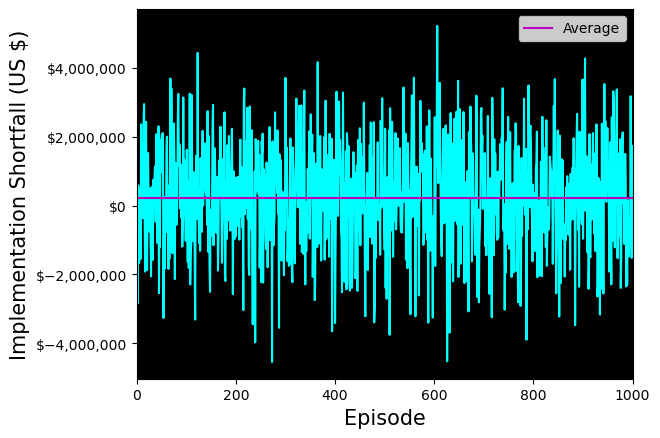

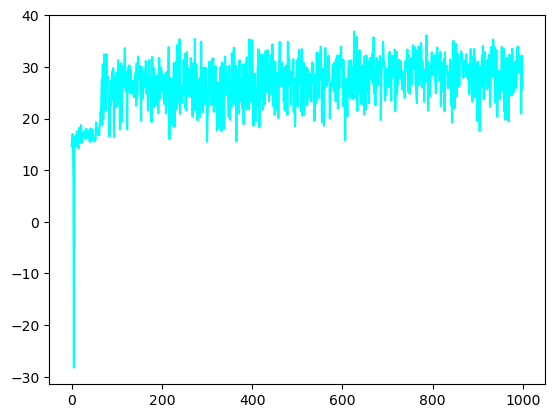

In [5]:
plot_shortfall_hist(shortfall_hist)
plt.plot(total_rewards, 'cyan', label='Total Rewards')